# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                          
Sample_179  H3BMA1;H3BUX1;Q13421-2;Q13421-3;Q13421-4   15.864
Sample_001  P55087;P55087-2;V9PBN7                     15.963
Sample_082  P10721;P10721-2                            16.317
Sample_080  P10599                                     18.567
Sample_198  C9J4G9;C9J539;P16278;P16278-3              12.449
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                                      
Sample_151  A0A087WSY4                                             16.993
Sample_068  K7EIS2;K7EKV3;K7EM70;K7EQL9;Q9BSG5;Q9BSG5-2;Q9BSG5-3   14.077
Sample_206  O60512                                                 13.186
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.638
            A0A075B6Q5                 13.244
            A0A075B6R2                 13.455
            A0A075B6S5                 13.544
            A0A087WSY4                 13.682
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.174
            Q9UI40;Q9UI40-2            13.656
            Q9UIW2                     10.554
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.968
            Q9UP79                     13.244
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.126,15.050,16.842,19.863,16.043,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.765,19.067,...,15.528,15.576,14.263,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.908,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.906,17.705,17.039,15.765,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.838,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.722,15.345,17.084,18.708,14.249,19.433,11.467,10.685
Sample_207,15.739,16.877,15.469,16.898,12.950,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.075,13.542,13.589,12.822,13.182,13.643,12.663,12.858,11.962,12.862
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.410,19.067,16.127,...,13.529,12.715,13.332,13.403,12.863,12.217,12.616,13.193,13.524,12.575
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.925,14.151,12.234,12.210,13.506,12.656,13.672,14.588,13.601,14.048
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,14.064,13.235,12.403,12.399,11.397,13.076,12.419,13.334,13.563,14.387
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.678,13.511,12.819,13.406,14.168,12.528,12.520,13.229,12.351,12.889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.743,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 354.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.77it/s]

100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  3.95it/s]

100%|██████████| 4/4 [00:00<00:00,  4.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.19it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.55it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.38it/s]

100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.08it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.36it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

100%|██████████| 6/6 [00:01<00:00,  4.07it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.20it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.88it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.25it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.85it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.83it/s]

100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.18it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.88it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.54it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.70it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.56it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.53it/s]

100%|██████████| 8/8 [00:02<00:00,  3.50it/s]

100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.03it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.00it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.89it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.81it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.62it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.56it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.37it/s]

100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.62it/s]

 30%|███       | 3/10 [00:00<00:01,  3.96it/s]

 40%|████      | 4/10 [00:00<00:01,  3.81it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.82it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.76it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.58it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.64it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.58it/s]

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.11it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.71it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.38it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.17it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.96it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.85it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.72it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.62it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:02<00:00,  3.42it/s]

100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.29it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.38it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.16it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.60it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.51it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.63it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.83it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.94it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.91it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.63it/s]

100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.91it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.65it/s]

 31%|███       | 4/13 [00:01<00:02,  3.17it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.16it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.86it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.62it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.58it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.62it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.65it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.55it/s]

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.04it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.21it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.05it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.10it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.23it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.26it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.34it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.39it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.53it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.54it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.50it/s]

100%|██████████| 14/14 [00:04<00:00,  3.43it/s]

100%|██████████| 14/14 [00:04<00:00,  3.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.87it/s]

 20%|██        | 3/15 [00:00<00:02,  4.15it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.80it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.14it/s]

 40%|████      | 6/15 [00:01<00:03,  2.71it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.57it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.56it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.83it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.84it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.01it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.91it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.09it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.13it/s]

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.035 0.008          0.813 0.292       0.143   
2             0.003 0.000      0.036 0.002          0.762 0.092       0.717   
3             0.004 0.004      0.037 0.007          0.770 0.113       0.723   
4             0.003 0.002      0.037 0.009          0.800 0.093       0.716   
5             0.003 0.000      0.036 0.002          0.829 0.100       0.778   
6             0.004 0.002      0.037 0.006          0.838 0.098       0.780   
7             0.004 0.000      0.037 0.004          0.838 0.097       0.779   
8             0.004 0.002      0.040 0.010          0.831 0.098       0.781   
9             0.004 0.002      0.037 0.007          0.821 0.088       0.811   
10            0.004 0.002      0.035 0.006          0.823 0.091       0.811   
11            0.004 0.002      0.034 0.005          0.816 0.094       0.799   
12            0.004 0.002      0.034 0.005          0.813 0.092       0.796   
13            0.005 0.003      0.045 0.020          0.811 0.092       0.796   
14            0.005 0.004      0.048 0.018          0.810 0.091       0.797   
15            0.004 0.002      0.042 0.013          0.807 0.094       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.236 0.123                  0.563 0.041        0.850   
2          0.102   0.733 0.074                  0.774 0.060        0.868   
3          0.105   0.739 0.083                  0.778 0.070        0.869   
4          0.114   0.749 0.079                  0.790 0.063        0.873   
5          0.093   0.800 0.080                  0.829 0.068        0.899   
6          0.096   0.804 0.078                  0.833 0.065        0.899   
7          0.096   0.803 0.077                  0.832 0.065        0.898   
8          0.104   0.801 0.083                  0.831 0.069        0.896   
9          0.100   0.812 0.073                  0.839 0.062        0.911   
10         0.099   0.812 0.072                  0.839 0.061        0.911   
11         0.108   0.803 0.079                  0.832 0.066        0.908   
12         0.108   0.800 0.078                  0.829 0.066        0.908   
13         0.107   0.799 0.079                  0.828 0.067        0.905   
14         0.109   0.799 0.080                  0.829 0.068        0.904   
15         0.107   0.797 0.079                  0.826 0.067        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.821 0.088        210.000 0.000  
2          0.060                  0.840 0.083        210.000 0.000  
3          0.066                  0.845 0.083        210.000 0.000  
4          0.064                  0.849 0.075        210.000 0.000  
5          0.056                  0.890 0.061        210.000 0.000  
6          0.055                  0.889 0.060        210.000 0.000  
7          0.057                  0.888 0.062        210.000 0.000  
8          0.057                  0.887 0.062        210.000 0.000  
9          0.052                  0.900 0.054        210.000 0.000  
10         0.053                  0.901 0.054        210.000 0.000  
11         0.055                  0.896 0.058        210.000 0.000  
12         0.055                  0.896 0.057        210.000 0.000  
13         0.055                  0.894 0.056        210.000 0.000  
14         0.055                  0.893 0.056        210.000 0.000  
15         0.055                  0.891 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 484.11it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.57it/s]

100%|██████████| 3/3 [00:00<00:00,  2.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.88it/s]

100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.21it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.41it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.04it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.16it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.79it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.60it/s]

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.70it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.35it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.03it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.78it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.40it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.45it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.28it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.12it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.05it/s]

100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.22it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.10it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.76it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.43it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.55it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.26it/s]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.92it/s]

 30%|███       | 3/10 [00:00<00:02,  3.06it/s]

 40%|████      | 4/10 [00:01<00:02,  2.67it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.49it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.83it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.94it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.97it/s]

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.07it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.09it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.65it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.46it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.24it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.36it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.41it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.55it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.67it/s]

100%|██████████| 11/11 [00:04<00:00,  2.75it/s]

100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.24it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.26it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.18it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.65it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.50it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.27it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.35it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.57it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.74it/s]

100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.78it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.90it/s]

 31%|███       | 4/13 [00:00<00:01,  4.57it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.13it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.38it/s]

 54%|█████▍    | 7/13 [00:01<00:02,  2.99it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.70it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.61it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.57it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.48it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.36it/s]

100%|██████████| 13/13 [00:04<00:00,  2.29it/s]

100%|██████████| 13/13 [00:04<00:00,  2.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.09it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.40it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.36it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.46it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.24it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.96it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.78it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.51it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.41it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.72it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.78it/s]

100%|██████████| 14/14 [00:04<00:00,  2.76it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.83it/s]

 20%|██        | 3/15 [00:00<00:02,  5.13it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.65it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.00it/s]

 40%|████      | 6/15 [00:01<00:03,  2.58it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.44it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.24it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.23it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.19it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.29it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.36it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.41it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.57it/s]

100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

100%|██████████| 15/15 [00:05<00:00,  2.65it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.041 0.012          0.155 0.326       0.018   
2             0.004 0.003      0.048 0.022          0.653 0.296       0.176   
3             0.004 0.003      0.050 0.021          0.745 0.093       0.613   
4             0.004 0.003      0.051 0.021          0.757 0.081       0.642   
5             0.005 0.004      0.061 0.026          0.769 0.082       0.703   
6             0.006 0.005      0.056 0.022          0.763 0.088       0.731   
7             0.005 0.005      0.057 0.020          0.769 0.087       0.754   
8             0.006 0.005      0.056 0.027          0.767 0.083       0.755   
9             0.005 0.004      0.043 0.017          0.766 0.081       0.752   
10            0.006 0.005      0.047 0.016          0.781 0.091       0.737   
11            0.006 0.005      0.047 0.016          0.772 0.078       0.790   
12            0.005 0.004      0.048 0.018          0.781 0.083       0.791   
13            0.005 0.004      0.049 0.024          0.778 0.082       0.790   
14            0.007 0.005      0.065 0.024          0.780 0.085       0.786   
15            0.005 0.004      0.051 0.022          0.779 0.083       0.784   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.040   0.031 0.068                  0.504 0.017        0.870   
2          0.110   0.261 0.142                  0.555 0.049        0.744   
3          0.110   0.667 0.084                  0.729 0.060        0.859   
4          0.111   0.689 0.080                  0.744 0.058        0.860   
5          0.114   0.728 0.077                  0.773 0.058        0.874   
6          0.110   0.741 0.075                  0.781 0.058        0.874   
7          0.098   0.757 0.071                  0.793 0.058        0.888   
8          0.107   0.756 0.072                  0.792 0.059        0.887   
9          0.107   0.754 0.071                  0.791 0.057        0.886   
10         0.089   0.754 0.069                  0.791 0.057        0.892   
11         0.109   0.776 0.071                  0.808 0.060        0.915   
12         0.097   0.781 0.066                  0.813 0.055        0.918   
13         0.102   0.779 0.070                  0.811 0.057        0.918   
14         0.096   0.778 0.065                  0.810 0.054        0.918   
15         0.090   0.776 0.060                  0.808 0.050        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.834 0.085        210.000 0.000  
2          0.112                  0.685 0.131        210.000 0.000  
3          0.043                  0.824 0.053        210.000 0.000  
4          0.047                  0.823 0.057        210.000 0.000  
5          0.044                  0.842 0.058        210.000 0.000  
6          0.045                  0.843 0.057        210.000 0.000  
7          0.047                  0.858 0.064        210.000 0.000  
8          0.048                  0.857 0.066        210.000 0.000  
9          0.046                  0.856 0.064        210.000 0.000  
10         0.044                  0.863 0.061        210.000 0.000  
11         0.041                  0.899 0.046        210.000 0.000  
12         0.040                  0.905 0.043        210.000 0.000  
13         0.040                  0.904 0.045        210.000 0.000  
14         0.040                  0.903 0.045        210.000 0.000  
15         0.040                  0.901 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1066.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.58it/s]

100%|██████████| 3/3 [00:00<00:00, 20.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.38it/s]

100%|██████████| 4/4 [00:00<00:00, 18.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.56it/s]

100%|██████████| 5/5 [00:00<00:00, 17.42it/s]

100%|██████████| 5/5 [00:00<00:00, 17.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.69it/s]

100%|██████████| 6/6 [00:00<00:00, 18.64it/s]

100%|██████████| 6/6 [00:00<00:00, 18.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.18it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.65it/s]

100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.15it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.88it/s]

100%|██████████| 8/8 [00:00<00:00, 14.45it/s]

100%|██████████| 8/8 [00:00<00:00, 15.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.79it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.09it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.70it/s]

100%|██████████| 9/9 [00:00<00:00, 13.65it/s]

100%|██████████| 9/9 [00:00<00:00, 14.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.91it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.55it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.95it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.37it/s]

100%|██████████| 10/10 [00:00<00:00, 12.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.27it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.59it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 12.72it/s]

 91%|█████████ | 10/11 [00:00<00:00, 11.90it/s]

100%|██████████| 11/11 [00:00<00:00, 12.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.19it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.80it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.27it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.43it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.53it/s]

100%|██████████| 12/12 [00:00<00:00, 13.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 25.88it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.56it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 18.17it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 16.67it/s]

100%|██████████| 13/13 [00:00<00:00, 15.32it/s]

100%|██████████| 13/13 [00:00<00:00, 16.87it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.00it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.57it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.04it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.50it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.95it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.04it/s]

100%|██████████| 14/14 [00:01<00:00, 13.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.79it/s]

 33%|███▎      | 5/15 [00:00<00:00, 16.07it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.70it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.80it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 14.09it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.81it/s]

100%|██████████| 15/15 [00:01<00:00, 14.30it/s]

100%|██████████| 15/15 [00:01<00:00, 14.55it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.019          0.000 0.000       0.000   
2             0.005 0.004      0.051 0.022          0.508 0.114       0.317   
3             0.004 0.003      0.041 0.012          0.574 0.112       0.444   
4             0.006 0.006      0.056 0.024          0.591 0.110       0.468   
5             0.003 0.002      0.037 0.011          0.609 0.098       0.502   
6             0.006 0.005      0.060 0.025          0.605 0.089       0.500   
7             0.006 0.004      0.065 0.028          0.663 0.085       0.614   
8             0.009 0.007      0.067 0.024          0.678 0.081       0.626   
9             0.005 0.005      0.052 0.019          0.702 0.085       0.679   
10            0.005 0.005      0.050 0.020          0.702 0.087       0.669   
11            0.005 0.004      0.050 0.022          0.699 0.087       0.666   
12            0.009 0.008      0.066 0.026          0.707 0.081       0.665   
13            0.008 0.009      0.062 0.029          0.705 0.090       0.656   
14            0.005 0.004      0.053 0.021          0.707 0.088       0.658   
15            0.006 0.005      0.063 0.025          0.708 0.091       0.660   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.747   
2          0.097   0.385 0.097                  0.546 0.058        0.637   
3          0.130   0.493 0.111                  0.602 0.071        0.693   
4          0.137   0.514 0.114                  0.617 0.073        0.691   
5          0.125   0.542 0.098                  0.632 0.066        0.713   
6          0.124   0.540 0.095                  0.630 0.062        0.709   
7          0.108   0.633 0.083                  0.693 0.065        0.783   
8          0.116   0.646 0.085                  0.704 0.064        0.786   
9          0.117   0.685 0.082                  0.733 0.064        0.822   
10         0.126   0.679 0.088                  0.730 0.069        0.819   
11         0.124   0.676 0.088                  0.727 0.068        0.815   
12         0.116   0.679 0.080                  0.731 0.061        0.812   
13         0.126   0.673 0.092                  0.727 0.071        0.811   
14         0.128   0.676 0.093                  0.729 0.070        0.811   
15         0.130   0.676 0.094                  0.730 0.071        0.805   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.700 0.076        210.000 0.000  
2          0.072                  0.572 0.078        210.000 0.000  
3          0.084                  0.651 0.091        210.000 0.000  
4          0.084                  0.648 0.091        210.000 0.000  
5          0.074                  0.661 0.088        210.000 0.000  
6          0.073                  0.655 0.088        210.000 0.000  
7          0.065                  0.726 0.074        210.000 0.000  
8          0.066                  0.733 0.076        210.000 0.000  
9          0.059                  0.780 0.068        210.000 0.000  
10         0.060                  0.776 0.071        210.000 0.000  
11         0.063                  0.773 0.073        210.000 0.000  
12         0.065                  0.761 0.080        210.000 0.000  
13         0.065                  0.759 0.079        210.000 0.000  
14         0.065                  0.754 0.077        210.000 0.000  
15         0.067                  0.748 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,12
score_time,14,14,8
test_precision,7,12,15
test_recall,9,12,9
test_f1,10,12,9
test_balanced_accuracy,10,12,9
test_roc_auc,10,12,9
test_average_precision,10,12,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.77it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.54it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.16it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.17it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.28it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.42it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.69it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.78it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.92it/s]

100%|██████████| 12/12 [00:04<00:00,  2.96it/s]

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.14it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 15.94it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.81it/s]

100%|██████████| 9/9 [00:00<00:00, 14.89it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.79it/s]

 30%|███       | 3/10 [00:00<00:01,  4.12it/s]

 40%|████      | 4/10 [00:01<00:01,  3.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.63it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.10it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.67it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.51it/s]

100%|██████████| 10/10 [00:03<00:00,  2.36it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


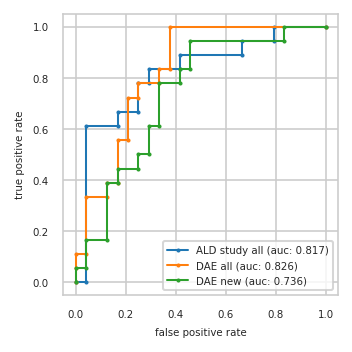

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.000 0.056
2          0.042 0.611   0.000 0.111   0.042 0.056
3          0.167 0.611   0.042 0.111   0.042 0.167
4          0.167 0.667   0.042 0.333   0.125 0.167
5          0.250 0.667   0.125 0.333   0.125 0.389
6          0.250 0.778   0.125 0.389   0.167 0.389
7          0.292 0.778   0.167 0.389   0.167 0.444
8          0.292 0.833   0.167 0.556   0.250 0.444
9          0.417 0.833   0.208 0.556   0.250 0.500
10         0.417 0.889   0.208 0.722   0.292 0.500
11         0.667 0.889   0.250 0.722   0.292 0.611
12         0.667 0.944   0.250 0.778   0.333 0.611
13         0.792 0.944   0.333 0.778   0.333 0.778
14         0.792 1.000   0.333 0.833   0.417 0.778
15         1.000 1.000   0.375 0.833   0.417 0.833
16           NaN   NaN   0.375 1.000   0.458 0.833
17           NaN   NaN   1.000 1.000   0.458 0.944
18           NaN   NaN     NaN   NaN   0.833 0.944
19           NaN   NaN     NaN   NaN   0.833 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q15848,H0Y7T8;P49418;P49418-2,P16519;P16519-3
2,G3XAP6;P49747;P49747-2,P26572,P51688
3,P61981,P61981,P30048;P30048-2
4,Q99983,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P31150,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P14174,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P00338;P00338-3,P14174,Q16799


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


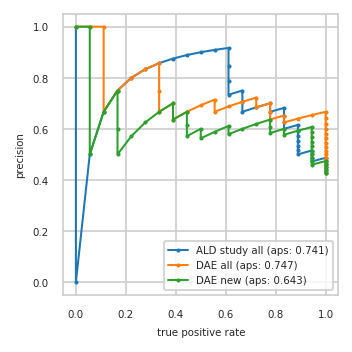

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.500 0.889     0.562 1.000     0.531 0.944
11         0.516 0.889     0.581 1.000     0.548 0.944
12         0.533 0.889     0.600 1.000     0.567 0.944
13         0.552 0.889     0.621 1.000     0.586 0.944
14         0.571 0.889     0.643 1.000     0.607 0.944
15         0.593 0.889     0.667 1.000     0.593 0.889
16         0.615 0.889     0.654 0.944     0.577 0.833
17         0.600 0.833     0.640 0.889     0.600 0.833
18         0.625 0.833     0.625 0.833     0.583 0.778
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.636 0.778     0.636 0.778
21         0.667 0.778     0.667 0.778     0.619 0.722
22         0.700 0.778     0.700 0.778     0.600 0.667
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.667 0.667     0.722 0.722     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.733 0.611     0.667 0.556     0.600 0.500
28         0.786 0.611     0.714 0.556     0.571 0.444
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.917 0.611     0.667 0.444     0.667 0.444
31         0.909 0.556     0.636 0.389     0.636 0.389
32         0.900 0.500     0.700 0.389     0.700 0.389
33         0.889 0.444     0.667 0.333     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.600 0.167
38         0.750 0.167     0.750 0.167     0.750 0.167
39         0.667 0.111     0.667 0.111     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


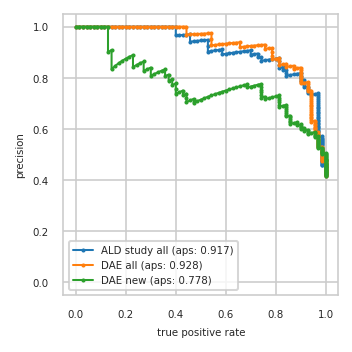

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


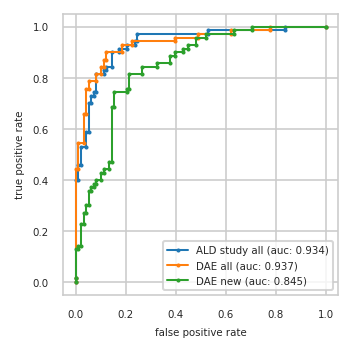

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}